# Evaluating BBox Regression CNN

A CNN was trained. VGG16 model architecture was used and the final fully connected layer was replaced with a regression layer. The model was trained on a subset of Tobacco800 dataset. This subset dataset has 776 images with signatures and corresponding bbox coordinates. 621 of these were used for training the model (90% train + 10% cross validation) and 155 were used for evaluating the dataset. The model had never seen any of these 155 evaluation images.

I saved the ground truth bbox values for all images in the eval dataset (```eval_images_ground_truth.py```) and the predicted bbox values for all images in the eval dataset (```predictions_cnn_bbox_regression.py```) in json format. These values will be used to find the intersection over area percentage which will tell us how close our predicted bounding boxes are to the real bounding boxes.

In [21]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

In [12]:
# Load both json files
eval_images_ground_truth_bbox = pd.read_json('eval_images_ground_truth_bbox.json')
eval_images_predicted_bbox_json = pd.read_json('eval_images_predicted_bbox.json')

In [16]:
eval_images_ground_truth_bbox

,fny38c00-page05_5.tif,dgw64a00.tif,ciy01a00-page02_2.tif,djy33f00-page02_2.tif,cvg13f00.tif,cjb54c00.tif,eey54f00_1.tif,eig45f00.tif,dlk65e00.tif,cnk41e00-page02_2.tif,...,dhr55d00-page02_2.tif,efm53d00.tif,cir10f00.tif,dat60e00_1.tif,gxv75f00_1.tif,dvw54f00_1.tif,dfb44f00-page4_4.tif,gat5aa00.tif,fjx9aa00.tif,eqp14e00-page02_2.tif
0,158,1018,636,1264,1443,820,706,645,1152,372,...,1576,1240,628,1648,634,669,605,1613,146,1436
1,1260,1586,756,1041,2630,1713,949,827,1927,1203,...,2023,2650,990,1986,450,986,492,2043,1641,1413
2,514,1358,849,1783,2227,1241,858,908,1807,1159,...,2004,1865,811,2176,905,901,960,2233,1200,2060
3,1360,1645,811,1227,2924,1799,1019,971,2099,1431,...,2207,2768,1053,2128,533,1084,569,2175,1854,1576


In [14]:
eval_images_predicted_bbox

,gmk15f00.tif,fzh11c00-var.tif,dny38c00_5.tif,fyg65f00.tif,fwe69c00.tif,gal01c00.tif,eat60e00.tif,ghz25e00.tif,eoc33a00-page02_2.tif,ecv85f00.tif,...,csj50c00.tif,gko55e00-page02_2.tif,cle30a00.tif,dsj50c00-page04_4.tif,fpi68d00.tif,dtf1aa00.tif,dkn80f00.tif,cxi59c00_1.tif,gxp01f00_1.tif,fbv15e00.tif
0,719,1329,199,546,873,779,1559,447,1378,622,...,1073,1408,256,861,1120,1083,618,180,531,1290
1,1182,1325,1416,1044,1210,1032,1563,2374,1405,805,...,1523,2173,2112,1513,1597,2055,889,1535,851,2048
2,987,1833,609,888,1429,1232,2078,1224,1877,937,...,1442,1956,835,1239,1815,1549,876,636,779,2181
3,1278,1585,1497,1156,1328,1112,1673,2642,1604,941,...,1635,2551,2476,1661,1894,2100,956,1631,945,2235


In [20]:
f = open('eval_images_ground_truth_bbox.json',)
ground_truth_values = json.load(f)
f.close()

f = open('eval_images_predicted_bbox.json',)
calculated_values = json.load(f)
f.close()

output_json_name = 'iou_bbox_regression.json'

iou_dict = dict()
for filename in eval_images_ground_truth_bbox.keys():
    # load ground truth and calculated coordinate values
    xmin_gt = ground_truth_values[filename][0]
    ymin_gt = ground_truth_values[filename][1]
    xmax_gt = ground_truth_values[filename][2]
    ymax_gt = ground_truth_values[filename][3]

    xmin_c = calculated_values[filename][0]
    ymin_c = calculated_values[filename][1]
    xmax_c = calculated_values[filename][2]
    ymax_c = calculated_values[filename][3]

    # Calculate iou
    # ground truth and calculated bbox areas
    gt_bbox_area = (xmax_gt - xmin_gt) * (ymax_gt - ymin_gt)
    calc_bbox_area = (xmax_c - xmin_c) * (ymax_c - ymin_c)

    # Coordinates of intersection
    xmin_inter = max(xmin_gt, xmin_c)
    ymin_inter = max(ymin_gt, ymin_c)
    xmax_inter = min(xmax_gt, xmax_c)
    ymax_inter = min(ymax_gt, ymax_c)

    if xmax_inter < xmin_inter or ymax_inter < ymin_inter:
        iou = 0.0
    else:
        intersection_area = (xmax_inter - xmin_inter) * (ymax_inter -
                                                         ymin_inter)
        iou = intersection_area / float(gt_bbox_area + calc_bbox_area -
                                        intersection_area)
        iou = round(iou * 100, 2)

    # Print filename and iou %age
    print(f'{filename} --> {iou}% accurate')

    # add to dict
    iou_dict.update({
        filename: {
            "ground_truth": [xmin_gt, ymin_gt, xmax_gt, ymax_gt],
            "calculated": [xmin_c, ymin_c, xmax_c, ymax_c],
            "intersection": [
                xmin_inter, ymin_inter, xmax_inter, ymax_inter
            ],
            "iou_in_percentage": iou
        }
    })

# writing json output
json_output = json.dumps(iou_dict, indent=4)
output_json_file = output_json_name
jsonFile = open(output_json_file, "w")
jsonFile.write(json_output)
jsonFile.close()

fny38c00-page05_5.tif --> 0.0% accurate
dgw64a00.tif --> 0.0% accurate
ciy01a00-page02_2.tif --> 0.0% accurate
djy33f00-page02_2.tif --> 0.0% accurate
cvg13f00.tif --> 40.41% accurate
cjb54c00.tif --> 32.87% accurate
eey54f00_1.tif --> 2.05% accurate
eig45f00.tif --> 67.38% accurate
dlk65e00.tif --> 25.53% accurate
cnk41e00-page02_2.tif --> 22.79% accurate
gdh93f00.tif --> 41.11% accurate
gfz10e00.tif --> 0.0% accurate
eck05f00_1.tif --> 40.73% accurate
gpq38e00-page02_1.tif --> 0.0% accurate
dmy31e00-page02_2.tif --> 0.0% accurate
enk41e00-page2_2.tif --> 18.55% accurate
dea05a00.tif --> 0.0% accurate
ehz25e00.tif --> 72.23% accurate
dwr29e00_2.tif --> 29.11% accurate
drd89c00-page02_2.tif --> 35.24% accurate
dqn43c00.tif --> 56.61% accurate
dgi64c00.tif --> 0.0% accurate
crr09c00_1.tif --> 47.83% accurate
eta15e00.tif --> 23.82% accurate
giy01a00-page02_2.tif --> 0.0% accurate
gcv85f00.tif --> 0.0% accurate
cmw13f00.tif --> 68.6% accurate
cji44a00.tif --> 16.94% accurate
diy01a00-pag

No handles with labels found to put in legend.


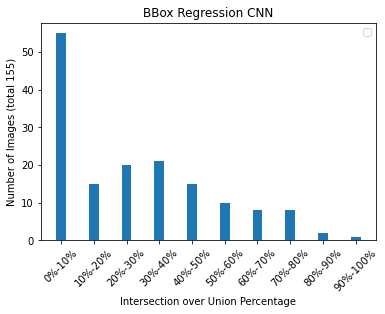

In [25]:
def visualize_evaluation(evaluation_json):
    f = open(evaluation_json, )
    evaluation_data = json.load(f)
    f.close()

    zero_to_ten, ten_to_twenty, twenty_to_thirty, thirty_to_forty, forty_to_fifthy, fifthy_to_sixty, \
    sixty_to_seventy, seventy_to_eighty, eighty_to_ninety, ninety_to_hundered = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

    for filename in evaluation_data.keys():
        if evaluation_data[filename]['iou_in_percentage'] < 10:
            zero_to_ten = zero_to_ten + 1
        elif evaluation_data[filename]['iou_in_percentage'] < 20:
            ten_to_twenty = ten_to_twenty + 1
        elif evaluation_data[filename]['iou_in_percentage'] < 30:
            twenty_to_thirty = twenty_to_thirty + 1
        elif evaluation_data[filename]['iou_in_percentage'] < 40:
            thirty_to_forty = thirty_to_forty + 1
        elif evaluation_data[filename]['iou_in_percentage'] < 50:
            forty_to_fifthy = forty_to_fifthy + 1
        elif evaluation_data[filename]['iou_in_percentage'] < 60:
            fifthy_to_sixty = fifthy_to_sixty + 1
        elif evaluation_data[filename]['iou_in_percentage'] < 70:
            sixty_to_seventy = sixty_to_seventy + 1
        elif evaluation_data[filename]['iou_in_percentage'] < 80:
            seventy_to_eighty = seventy_to_eighty + 1
        elif evaluation_data[filename]['iou_in_percentage'] < 90:
            eighty_to_ninety = eighty_to_ninety + 1
        elif evaluation_data[filename]['iou_in_percentage'] <= 100:
            ninety_to_hundered = ninety_to_hundered + 1

    # Plot
    x_axis_labels = [
        '0%-10%', '10%-20%', '20%-30%', '30%-40%', '40%-50%', '50%-60%', '60%-70%',
        '70%-80%', '80%-90%', '90%-100%'
    ]
    frequency = [
        zero_to_ten, ten_to_twenty, twenty_to_thirty, thirty_to_forty,
        forty_to_fifthy, fifthy_to_sixty, sixty_to_seventy, seventy_to_eighty,
        eighty_to_ninety, ninety_to_hundered
    ]

    return x_axis_labels, frequency



iou_bbox_regression_json = 'iou_bbox_regression.json'
x_axis_labels, frequency = visualize_evaluation(iou_bbox_regression_json)


fig = plt.figure()
w = 0.3
X_axis = np.arange(len(x_axis_labels))

plt.bar(X_axis, frequency, w)

plt.xticks(X_axis, x_axis_labels)
plt.xticks(rotation=45)
plt.xlabel("Intersection over Union Percentage")
plt.ylabel("Number of Images (total 155)")
plt.title("BBox Regression CNN")
plt.legend()
plt.show()